In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

In [2]:
rdkit.__version__

'2022.03.2'

#### Reference:
1. S. A. Wildman and G. M. Crippen, JCICS 39, 868-873 (1999)
2. P. Labute, JMGM 18, 464-477 (2000)

In [3]:
mol = Chem.MolFromSmiles('CC(C)NCO')

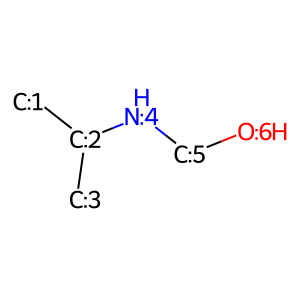

In [4]:
for i,a in enumerate(mol.GetAtoms()):
    a.SetAtomMapNum(i+1)

Draw.MolToImage(mol)

### Question 1: LogP

Due to reference: [1]

> If the goal is only the final log P value, unrealistic individual contributions need not be a concern. However, if one needs to estimate the lipophilicity of a part of a molecule, it is important the individual atomic contributions be more reasonable while maintaining an accurate overall calculated log P.

The `logP` of the fragment of the molecule cannot be correctly predicted, thus, the atomic contributation has to be explicitly calculated, and this is a **must** option in `rdkit`.

In [5]:
# Examples:
print('Before: ',end='')
print(Descriptors.MolLogP(mol))

print('After : ',end='')
print(Descriptors.MolLogP(Chem.AddHs(mol)))

Before: -0.06579999999999997
After : -0.06579999999999997


With this in mind, the overall atomic contributions can be calculated by:

In [6]:
contris = rdMolDescriptors._CalcCrippenContribs(Chem.AddHs(mol))

In [7]:
print(contris)

[(0.1441, 2.503), (-0.2051, 2.731), (0.1441, 2.503), (-0.7096, 2.173), (-0.2035, 2.753), (-0.2893, 0.8238), (0.123, 1.057), (0.123, 1.057), (0.123, 1.057), (0.123, 1.057), (0.123, 1.057), (0.123, 1.057), (0.123, 1.057), (0.2142, 0.9627), (0.123, 1.057), (0.123, 1.057), (-0.2677, 1.395)]


Returned is a 2-tuple list, the first term is atomic contribution for `LogP`, the other one is for `MR`

In [8]:
print('Sum of LogP: ',end='')
print(sum([i[0] for i in contris]))

print('Sum of MR  : ',end='')
print(sum([i[1] for i in contris]))

Sum of LogP: -0.06579999999999997
Sum of MR  : 25.357499999999995


In [9]:
# This can be further checked by:

print(rdMolDescriptors.CalcCrippenDescriptors(mol))

(-0.06579999999999997, 25.357499999999995)


### Question 2: SlogP_VSA(n)

Its definition: https://www.rdkit.org/docs/source/rdkit.Chem.MolSurf.html#rdkit.Chem.MolSurf.SlogP_VSA1

In [10]:
lvsa = [getattr(Descriptors,f'SlogP_VSA{i+1}') for i in range(12)]
mol_hs = Chem.AddHs(mol)      # be aware in here, hydrogens has to be added, otherwise, results will be different
for i,f in enumerate(lvsa):
    print(f'SlogP_VSA_{i+1}: ',f(mol_hs))

SlogP_VSA_1:  5.309813353288376
SlogP_VSA_2:  19.240820342592347
SlogP_VSA_3:  0.0
SlogP_VSA_4:  0.0
SlogP_VSA_5:  26.040611240123337
SlogP_VSA_6:  0.0
SlogP_VSA_7:  1.4118420783282006
SlogP_VSA_8:  0.0
SlogP_VSA_9:  0.0
SlogP_VSA_10:  0.0
SlogP_VSA_11:  0.0
SlogP_VSA_12:  0.0


In [11]:
# Or, this can be done in a more concise way:
vs = rdMolDescriptors.SlogP_VSA_(mol_hs)
print(vs)

[5.309813353288376, 19.240820342592347, 0.0, 0.0, 26.040611240123337, 0.0, 1.4118420783282006, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
# atomic contribution
labutes = list(rdMolDescriptors._CalcLabuteASAContribs(mol_hs)[0])  # values
print(labutes)

[6.851892117295679, 6.017892468349645, 6.851892117295679, 5.309813353288376, 6.682920025902854, 5.1088081911072125, 1.3707585561702202, 1.3707585561702202, 1.3707585561702202, 1.3707585561702202, 1.3707585561702202, 1.3707585561702202, 1.3707585561702202, 1.4118420783282006, 1.3707585561702202, 1.3707585561702202, 1.4311996572326342]


Time to reproduce:

Check the source codes:
[cbins](https://github.com/rdkit/rdkit-orig/blob/master/Code/GraphMol/Descriptors/MolSurf.cpp#L256) :https://github.com/rdkit/rdkit-orig/blob/master/Code/GraphMol/Descriptors/MolSurf.cpp#L256

Or from the paper [2], we can get a more comprehensive partation list:

In [13]:
cbins = [-0.4,-0.2,0.0,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6]

# There are `11` values, in total `12` intervals with the consideration of
# boundaries (negative and positive infinity).

# for explanation used only
cbins.insert(0, -100000000.0)
cbins.append(100000000.0)

In [14]:
parts = [0.0 for i in range(12)]
for t,v in enumerate(contris):
    for i in range(12):
        if v[0] >= cbins[i] and v[0] < cbins[i+1]:
            break
    parts[i] += labutes[t]

for i,t in enumerate(parts):
    print(f'SlogP_VSA_{i+1}: ',t)

SlogP_VSA_1:  5.309813353288376
SlogP_VSA_2:  19.240820342592347
SlogP_VSA_3:  0.0
SlogP_VSA_4:  0.0
SlogP_VSA_5:  26.040611240123337
SlogP_VSA_6:  0.0
SlogP_VSA_7:  1.4118420783282006
SlogP_VSA_8:  0.0
SlogP_VSA_9:  0.0
SlogP_VSA_10:  0.0
SlogP_VSA_11:  0.0
SlogP_VSA_12:  0.0


Calculation of **MR** can be done in the similar way, left for practice.

Bins used:

```
MR_bins = [1.29, 1.82, 2.24, 2.45, 2.75, 3.05, 3.63, 3.8, 4.0]
```

### Conclusion

For molecular descriptor calculated by:

* `rdkit.Chem.Descriptors.MolLogP` calculates result from reference [1]
* `rdkit.Chem.rdMolDescriptors.SlogP_VSA_` or `rdkit.Chem.Descriptors.SlogP_VSA{n}` is the **further** partion from reference [2]